# Classification after Clustering with Agglomerative Clustering

### Import CSV and Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay




warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"./data/clustered_data.csv")
# Print shape of dataset
print(df.shape)

(2240, 22)


**Split X and y**
- Why do we split our data?
> Training Dataset is the part of Original Dataset that we use to train our ML model. The model learns on this data by running the algorithm and maps a function F(x) where “x” in the independent variable (inputs) for “y” where “y” is the dependent variable(output).

In [3]:
X = df.drop("cluster", axis=1) #dropping the target column which is 'cluster'
y = df["cluster"]

## Grid Search

- Why do we use Grid Search?

`GridSearchCV` is a technique to search through the best parameter values from the given set of the grid of parameters. It is basically a cross-validation method. the model and the parameters are required to be fed in. Best parameter values are extracted and then the predictions are made.

## Select the best model
- so here we have some list of the best classification algorithms we imported. Now we will compare each model's score and see which model is performing better than rest of the others

In [28]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics 

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

- ### We will create a generic function to check each model's performance so that we can compare those

In [94]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    

    models_list = []
    scores = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_pred = model.predict(X_test)

        score = accuracy_score(y_test,y_pred)
        
        model_name = list(models.keys())[i]
        print(f'---- score for --- {model_name} ----')
        print(f"{score}")
        models_list.append(model_name)
        scores.append(score)
    
    print()
    
    report = pd.DataFrame()
    report['Model_name'] = models_list
    report['Score'] = scores        
    return report

### Let's check the report

In [97]:
report = evaluate_models(X, y, models)

---- score for --- Random Forest ----
0.8973214285714286
---- score for --- Decision Tree ----
0.8883928571428571
---- score for --- Gradient Boosting ----
0.9129464285714286
---- score for --- Logistic Regression ----
0.9308035714285714
---- score for --- K-Neighbors Classifier ----
0.8191964285714286
---- score for --- XGBClassifier ----
0.9129464285714286
---- score for --- CatBoosting Classifier ----
0.9241071428571429
---- score for --- AdaBoost Classifier ----
0.9263392857142857



In [100]:
report.sort_values('Score')

,Model_name,Score
4,K-Neighbors Classifier,0.819196
1,Decision Tree,0.888393
0,Random Forest,0.897321
2,Gradient Boosting,0.912946
5,XGBClassifier,0.912946
6,CatBoosting Classifier,0.924107
7,AdaBoost Classifier,0.926339
3,Logistic Regression,0.930804


- ### From the report above we can see that the logistic regression model performed the best, so we will continue training our model using logistic regression algorithm.

### Split into Train and test data

- **Do you know why we split the train and test dataset?**
> The train test split technique can be used for classification and regression problems to test machine learning algorithms. The procedure takes the given dataset and splits it into two subsets: ```Training data/train set:``` it is used to train the algorithm and fit the machine learning model
then we have ```test data/test set``` which is basically a different data for which we know the values but this data was never shown to the model before. Thus if the model after training is performing good on test set as well then we can say that the Machine Learning model is good.

In [113]:
# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xt, y, random_state=42, test_size=0.3)

X_train

,Parental Status,Children,Total_Spending
994,1,2,108.0
2162,1,1,414.0
906,0,0,1449.0
572,1,1,177.0
1877,0,0,1515.0
...,...,...,...
1638,1,2,41.0
1095,1,1,424.0
1130,1,1,957.0
1294,1,2,62.0


### Let's do hyperparameter tuning
- **And what's it actually?**

> A Machine Learning model is defined as a mathematical model with a number of parameters that need to be learned from the data. By training a model with existing data, we are able to fit the model parameters. 
However, there is another kind of parameter, known as Hyperparameters, that cannot be directly learned from the regular training process. They are usually fixed before the actual training process begins. These parameters express important properties of the model such as its complexity or how fast it should learn. 

In [115]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.random.randint(100,500, 10),
    'multi_class': ['auto', 'ovr', 'multinomial'],
    "C":np.logspace(-3,3,7),
    "penalty":["l1","l2"]

    
}

logreg=LogisticRegression()

logreg_cv=GridSearchCV(logreg,params,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'max_iter': 113, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9413277804997551


### So we got our best parameters. Let's now train the model with those parameters.

In [116]:
best_lr_model = LogisticRegression(
    C = 1000, 
    max_iter =  113,
    multi_class =  'auto', 
    penalty =  'l2', 
    solver =  'lbfgs'
)

**Initialize model with best parameters**

### Let's check the report now

In [117]:
best_model = best_lr_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("Logistic regression")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

Logistic regression
Accuracy Score value: 0.9405
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       277
           1       0.96      0.96      0.96       256
           2       0.91      0.94      0.93       139

    accuracy                           0.94       672
   macro avg       0.94      0.94      0.94       672
weighted avg       0.94      0.94      0.94       672



## Confusion matrix of the model
- **What is confusion matrix ?**
> The confusion matrix is a matrix used to determine the performance of the classification models for a given set of test data. It can only be determined if the true values for test data are known. The matrix itself can be easily understood, but the related terminologies may be confusing.

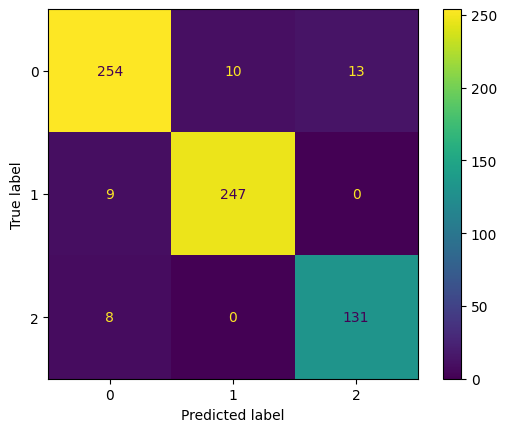

In [118]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

- **Reports**

**We can see, that the model performed pretty well.**
- we have used logistic regression as it performed well than other models
- We got a good accuracy while predicting the test dataset.